# PyDCM JupyterLab Notebook to fit MDCM charges from a Gaussian Cube file

## Notes:

https://pubs.rsc.org/en/content/articlepdf/1953/tf/tf9534900358## Setup: Define these variables for your system:
You should check and set these variables by hand for your system

In [21]:
# The Gaussian-format cube file containing electron density:
refDensCube="/home/unibas/boittier/DensityTests/water_5_5_4/4_Water_5_5_4.den.cube"
# The Gaussian-format cube file containing electrostatic potential energy:
refPotCube="/home/unibas/boittier/DensityTests/water_5_5_4/4_Water_5_5_4.pot.cube"
# The root folder for your fitting project
projDir="/home/unibas/boittier/pydcm-1.2/water_5_5_5-4"
# The bin directory containing the MDCM scripts and programs
refBinDir="/home/unibas/boittier/pydcm-1.2/bin"
# The total charge of the molecule to be fitted (a.u.)
qtot=0.0

# The port to use for the local web browser (to view molecules in NGL). Make sure nobody else is using it already!
webPort='8880'

# The name of a Slurm partition allowing jobs to run for up to 2 hours with 4 cores
shortQ='short'
longQ='infinite'

# The desired isodensity surface to use for viewing potential energy surfaces (a.u)
isoSurf=0.001

## Step 1: Load files and view reference ESP

pydcm-1.2pydcm-1.2### Create the desired folder structure and copy files there
This will use the "projDir" you selected as the root directory for this fitting project, copying reference files there and creating new files and subfolders as necessary.

In [22]:
import os
from pathlib import Path
from shutil import copyfile

workdir=projDir + '/'
refdir=workdir+'ref/'
htmldir=workdir+'html/'
bindir=refBinDir+'/'
pdbfile=refdir+'mol.pdb'

toang=0.529177

elements=['H','HE','LI','BE','B','C','N','O','F','NE','NA','MG','AL','SI','P','S','CL','AR','K','CA','SC',
         'TI','V','CR','MN','FE','CO','NI','CU','ZN','GA','GE','AS','SE','BR','KR','RB','SR','Y','ZR','NB',
         'MO','TC','RU','RH','PD','AG','CD','IN','SN','SB','TE','I','XE','CS','BA','LA','CE','PR','ND','PM',
         'SM','EU','GD','TB','DY','HO','ER','TM','YB','LU','HF','TA','W','RE','OS','IR','PT','AU','HG','TL',
         'PB','BI','PO','AT','RN']

Path(workdir).mkdir(parents=True, exist_ok=True)
try:
    os.chdir(workdir)
except FileNotFoundError:
    print("Could not change to project root directory "+workdir)
    raise FileNotFoundError
Path(refdir).mkdir(parents=True, exist_ok=True)
Path(htmldir).mkdir(parents=True, exist_ok=True)

densCube=refdir+os.path.basename(refDensCube)
try:
    copyfile(refDensCube,densCube)
except:
    print("Could not copy "+refDensCube+" to "+densCube)
    raise FileNotFoundError
potCube=refdir+os.path.basename(refPotCube)
try:
    copyfile(refPotCube,potCube)
except:
    print("Could not copy "+refPotCube+" to "+potCube)
    raise FileNotFoundError
print("Changed to working directory "+workdir)

# Get the number of atoms in the molecule from the cube file
df=open(densCube,'r')
nl=1
natm=0
coords=[]
for line in df:
    if nl==3:
        a=line.split()
        natm=int(a[0])
    if nl>natm+6:
        exit
    if nl>6 and nl <= natm+6:
        a=line.split()
        coords.append([])
        coords[nl-7]=[elements[int(a[0])-1],float(a[2])*toang,float(a[3])*toang,float(a[4])*toang]
    nl=nl+1
df.close()

print(str(natm)+' atoms in molecule')

print('writing PDB file ',pdbfile)
pf=open(pdbfile,'w')
pf.write('REMARK: FILE AUTOMATICALLY GENERATED FROM '+densCube+'\n')
for i in range(0,natm):
    pf.write('ATOM   %4i  %-3s MOL     1     %7.3f %7.3f %7.3f  1.00  0.00      MOL\n' %(i+1,coords[i][0]+str(i+1),coords[i][1],
                                                                               coords[i][2],coords[i][3]))
pf.write('END')
pf.close()

Changed to working directory /home/unibas/boittier/pydcm-1.2/water_5_5_5-4/
3 atoms in molecule
writing PDB file  /home/unibas/boittier/pydcm-1.2/water_5_5_5-4/ref/mol.pdb


### The following cell starts a local web server in the background, allowing JavaScript to access local files in your filesystem for NGL Viewer to work properly

The local web server is required to view structures and surfaces with NGL viewer in this notebook. The JavaScript version of NGL is used here, meaning it has no direct access to open even local files unless referenced and shared as a URL. To access local files using a URL a local web server needs to be running, and to avoid making changes to the firewall an SSH tunnel needs to be set up for the port you wish to use. See installation instructions for more details.

If it worked then you should see something like "Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ..." in the console where you started jupyter-lab. The port will be the webPort you set above.

In [23]:
import os
from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

try:
    os.chdir(workdir)
except FileNotFoundError:
    print("Could not change to project root directory "+ workdir)
    raise FileNotFoundError

def run_http():
    script=bindir+'simple-cors-http-server.py' 
    if not os.path.isfile(script):
        print("Error: could not open "+ script)
        raise FileNotFoundError
    print('python ' + script + " " + webPort)
    os.system('python ' + script + " " + webPort )

jobs.new('run_http()')
jobs.status()
cwd=os.getcwd()
print("Web server running in directory "+cwd+", URLs are relative to this path")
print("If you change the project directory, you need to restart Jupyter-Lab to restart this server and create a new root for URLs")

Running jobs:
0 : run_http()

python /home/unibas/boittier/pydcm-1.2/bin/simple-cors-http-server.py 8880
Web server running in directory /home/unibas/boittier/pydcm-1.2/water_5_5_5-4, URLs are relative to this path
If you change the project directory, you need to restart Jupyter-Lab to restart this server and create a new root for URLs


### The next cell loads your selected reference Gaussian cube files and prepares an HTML script to plot the ESP on a molecular isodensity surface

In [30]:
import os
import webbrowser
import IPython

# Get range of ESP values from reference CUBE files
line=1
natm=0
maxESP=0.0
with open(densCube) as df, open(potCube) as pf: 
    for l1, l2 in zip(df, pf):
        a = l1.split()
        b = l2.split()
        if line == 3:
            natm=int(a[0])
        if line > natm+6:
            if(len(a) != len(b)):
                print("Error: density and ESP cube files do not match!")
                raise Exception
            for i in range(0,len(a)):
                if float(a[i]) <= isoSurf and abs(float(b[i])) > maxESP:
                    maxESP = abs(float(b[i]))
        line=line+1
print("ESP range: -"+str(maxESP)+" to "+str(maxESP)+" a.u.")
        
f = open(htmldir+"refESP.html", "w")
f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
  <script>
    var densFile = 'http://localhost:%s/ref/%s' 
    var espFile = 'http://localhost:%s/ref/%s'
    var pdbFile = 'http://localhost:%s/ref/%s'

    document.addEventListener("DOMContentLoaded", function () {
      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(pdbFile),
      ]).then(function(comp) {
        var pdbComp = comp[0]


        pdbComp.addRepresentation("ball+stick");
        pdbComp.addRepresentation("label",{labelType: "atomname",
                                           color: "cyan"});
        stage.autoView();
      } );
    });

    document.addEventListener("DOMContentLoaded", function () {
      var stage2 = new NGL.Stage("viewport2");

      Promise.all([
        stage2.loadFile(densFile),
        stage2.loadFile(espFile)
      ]).then(function(comp) {
        var densComp = comp[0]
        var espComp = comp[1]


        densComp.addRepresentation("surface",{isolevel: "%8.4f",
                                              isolevelType: 'value',
                                              opacity: 0.95,
                                              side: 'front',
                                              colorScheme: 'volume',
                                              colorVolume: espComp.volume,
                                              colorScale: [ 0xff0000, 0xffff00, 0x00ff00, 0x00ffff, 0x0000ff ],
                                              colorMode: 'rgb',
                                              colorDomain: [ %8.4f, %8.4f ]
                                              });
        stage2.autoView();
        stage2.viewerControls.zoom(-0.5);
      } );
    });

  </script>
  <h3>NGL Cube File Visualization</h3>
  <table><tr><td>
  <div id="viewport" style="width:500px; height:500px;"></div><br><p>Atom numbering</p>
  </td><td>
  <div id="viewport2" style="width:500px; height:500px;"></div><br><p>ESP from %s</p>
  </td></tr></table>
  <p><div id="viewer"></div></p>
  <script>
    document.getElementById("viewer").innerHTML = densFile;
  </script>
</body>
</html>
''' % (webPort,os.path.basename(densCube),webPort,os.path.basename(potCube),webPort,os.path.basename(pdbfile),
       isoSurf,-maxESP,maxESP,potCube)
)
f.close()
print(webPort, htmldir, pdbfile)
# generate a URL and open in an iframe
url = 'http://localhost:'+webPort+'/html/refESP.html'
print(url)
IPython.display.IFrame(src=url,width='1120',height='750')


ESP range: -0.0638735 to 0.0638735 a.u.
8880 /home/unibas/boittier/pydcm-1.2/water_5_5_5-4/html/ /home/unibas/boittier/pydcm-1.2/water_5_5_5-4/ref/mol.pdb
http://localhost:8880/html/refESP.html


## Step 2: Fit multipoles to reference ESP

It is generally too expensive to use Differential Evolution to fit a MDCM for a whole molecule directly. Instead we fit atomic charge models with just a few charges, then combine these to fit fragment charge models, then combine those to build the molecular MDCM. As QM reference ESP data are for the whole molecule, we need to obtain reference atomic and fragment ESPs to fit to somehow. We therefore fit high-ranking atomic multipoles first (using a fast least-squares approach), then use the resulting atomic multipoles to provide a reference atomic or fragment ESP and fit atomic or fragment charge models to that.

In the following cell the least-squares fit of a high-ranking multipole expansion to the molecular ESP is performed.

In [31]:
import subprocess
from IPython.display import Image
from subprocess import PIPE

mtpdir=workdir+'1-mtpfit/'
mtpfile=mtpdir+'fitted-mtpl.dat'
Path(mtpdir).mkdir(parents=True, exist_ok=True)

try:
    os.chdir(mtpdir)
except FileNotFoundError:
    print("Could not change to mtp fitting directory " + mtpdir)
    raise FileNotFoundError

script=bindir+"mtpfit.py"
print(script)
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError

# Run Least-Squares fit of atomic multipoles to ESP in reference cube file
if not os.path.isfile(mtpfile):
    eFile = open("py_err.log", "w")
    oFile = open("py_out.log", "w")
    subprocess.run(['python',script,'-pot',potCube,'-dens',densCube,'-lmax','5','-qtot',str(qtot)], stdout=oFile,stderr=eFile)

# Generate a cube file to visualize the multipolar ESP and compare to the reference ESP
script=bindir+'pcubefit.x'

if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError
    
if not os.path.isfile('ditriantapole_expansion.cube'):
    logFile=open('fitted-mtpl-cube.log','w')
    errFile=open('errlog','w')
    subprocess.run([script,'-v','-generate','-multipole','-esp',potCube,'-dens',densCube,'-xyz',mtpfile],stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()

# Generate slices showing errors in R
rLogFile=open('rLog','w')
rErrFile=open('rErrlog','w')
script=bindir+'visualize.r'
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError
if not os.path.isfile('comparison.png'):
    subprocess.run([script],stdout=rLogFile,stderr=rErrFile)

# Analyze generated ESP cube file to get statistics (RMSE of fit etc.)
script=bindir+'pcubefit.x'
if not os.path.isfile('analyze-mtpl-cube.log'):
    logFile=open('analyze-mtpl-cube.log','w')
    errFile=open('errlog2','w')
    subprocess.run([script,'-v','-analysis','-esp',potCube,'-esp2','ditriantapole_expansion.cube','-dens',densCube],stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()

rmse=[]
maxErr=[]
npts=[]
logFile=open('analyze-mtpl-cube.log','r')
for line in logFile:
    a=line.split()
    if len(a) > 3: 
        if a[0] == 'Total':
            rmse.append(float(a[1]))
            maxErr.append(float(a[2]))
            npts.append(int(a[3]))
        if a[0] == 'Close':
            rmse.append(float(a[8]))
            maxErr.append(float(a[9]))
            npts.append(int(a[10]))
        if a[0] == 'Mid-range':
            rmse.append(float(a[7]))
            maxErr.append(float(a[8]))
            npts.append(int(a[9]))
        if a[0] == 'Far-range':
            rmse.append(float(a[5]))
            maxErr.append(float(a[6]))
            npts.append(int(a[7]))
            
os.chdir(workdir)
                
# Now create a function to generate HTML to compare two ESP surfaces
def writeNGLHTML(htmlF,densF1,potF1,densF2,potF2,rmse,maxErr,npts,imgFile):
    f = open(htmldir+htmlF, "w")
    f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
<!--  <script src="https://unpkg.com/ngl"></script>-->
  <script>
    var densFile = 'http://localhost:%s/%s' 
    var espFile = 'http://localhost:%s/%s'

    document.addEventListener("DOMContentLoaded", function () {
      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(densFile),
        stage.loadFile(espFile)
      ]).then(function(comp) {
        var densComp = comp[0]
        var espComp = comp[1]


        densComp.addRepresentation("surface",{isolevel: "%8.4f",
                                              isolevelType: 'value',
                                              opacity: 0.95,
                                              side: 'front',
                                              colorScheme: 'volume',
                                              colorVolume: espComp.volume,
                                              colorScale: [ 0xff0000, 0xffff00, 0x00ff00, 0x00ffff, 0x0000ff ],
                                              colorMode: 'rgb',
                                              colorDomain: [ %8.4f, %8.4f ]
                                              });
        stage.autoView();
        stage.viewerControls.zoom(-0.5);
      } );
    });

    var densFile2 = 'http://localhost:%s/%s' 
    var espFile2 = 'http://localhost:%s/%s'

    document.addEventListener("DOMContentLoaded", function () {
      var stage2 = new NGL.Stage("viewport2");

      Promise.all([
        stage2.loadFile(densFile2),
        stage2.loadFile(espFile2)
      ]).then(function(comp2) {
        var densComp2 = comp2[0]
        var espComp2 = comp2[1]


        densComp2.addRepresentation("surface",{isolevel: "%8.4f",
                                              isolevelType: 'value',
                                              opacity: 0.95,
                                              side: 'front',
                                              colorScheme: 'volume',
                                              colorVolume: espComp2.volume,
                                              colorScale: [ 0xff0000, 0xffff00, 0x00ff00, 0x00ffff, 0x0000ff ],
                                              colorMode: 'rgb',
                                              colorDomain: [ %8.4f, %8.4f ]
                                              });
        stage2.autoView();
        stage2.viewerControls.zoom(-0.5);
      } );
    });
  </script>
  <h3>NGL Cube File Visualization</h3>
  <table><tr><td>
  <div id="viewport" style="width:500px; height:500px;"></div><br><p>ESP from %s</p>
  </td><td>
  <div id="viewport2" style="width:500px; height:500px;"></div><br><p>ESP from %s</p>
  </td></tr></table>
  <table cellpadding="5">
  <tr><td><b>Measure</b></td><td><b>RMSE[kcal/mol/e]</b></td><td><b>MaxError[kcal/mol/e]</b></td><td><b>NPoints</b></td></tr>
  <tr><td><b>Total                        </b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Close  (  1.20 < r <   1.66 )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Mid-range ( 1.66 < r <  2.20)</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Far-range ( 2.20 < r        )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  </table>
  <h2><br>ESP Slice Data (ESP and Errors in each plane)<br></h2>
  <img src="http://localhost:%s/%s" alt="Slice Data" style="width:1020px;">
</body>
</html>
''' % (webPort,densF1,webPort,potF1,isoSurf,-maxESP,maxESP,webPort,densF2,webPort,potF2,isoSurf,
       -maxESP,maxESP,potF1,potF2,rmse[0],maxErr[0],npts[0],
       rmse[1],maxErr[1],npts[1],rmse[2],maxErr[2],npts[2],rmse[3],maxErr[3],npts[3],webPort,imgFile)
    )
    f.close()

writeNGLHTML('mtpFit.html','ref/'+os.path.basename(densCube),'ref/'+os.path.basename(potCube),'ref/'+os.path.basename(densCube),'1-mtpfit/ditriantapole_expansion.cube',
            rmse,maxErr,npts,'1-mtpfit/comparison.png')
# generate a URL and display in an iframe
url = 'http://localhost:'+webPort+'/html/mtpFit.html'
IPython.display.IFrame(src=url,width='1120',height='1550')

# display the slices as well
#Image("1-mtpfit/comparison.png")

/home/unibas/boittier/pydcm-1.2/bin/mtpfit.py


## Step 3: Fit atomic charge models using atomic multipoles from step 2

Now the atomic multipoles are available, we can fit atomic charge models to them. This step is fast for 1 or 2 charges, but already takes up to an hour or so for 4 charges if the ESP grid you provided contains a lot of grid points (i.e. is a relatively fine or large grid)


## 1Charges Per Atom:
Atom 1 final RMSE: 2.599850622 kcal/mol
Atom 2 final RMSE: 1.527968901 kcal/mol
Atom 3 final RMSE: 0.3995072317 kcal/mol

## 2Charges Per Atom:
Atom 1 final RMSE: 1.621803338 kcal/mol
Atom 2 final RMSE: 0.1879262173 kcal/mol
Atom 3 final RMSE: 0.2634483992 kcal/mol

## 3Charges Per Atom:
Atom 1 final RMSE: 0.3383629709 kcal/mol
Atom 2 final RMSE: 0.1748970452 kcal/mol
Atom 3 final RMSE: 0.1917743404 kcal/mol


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

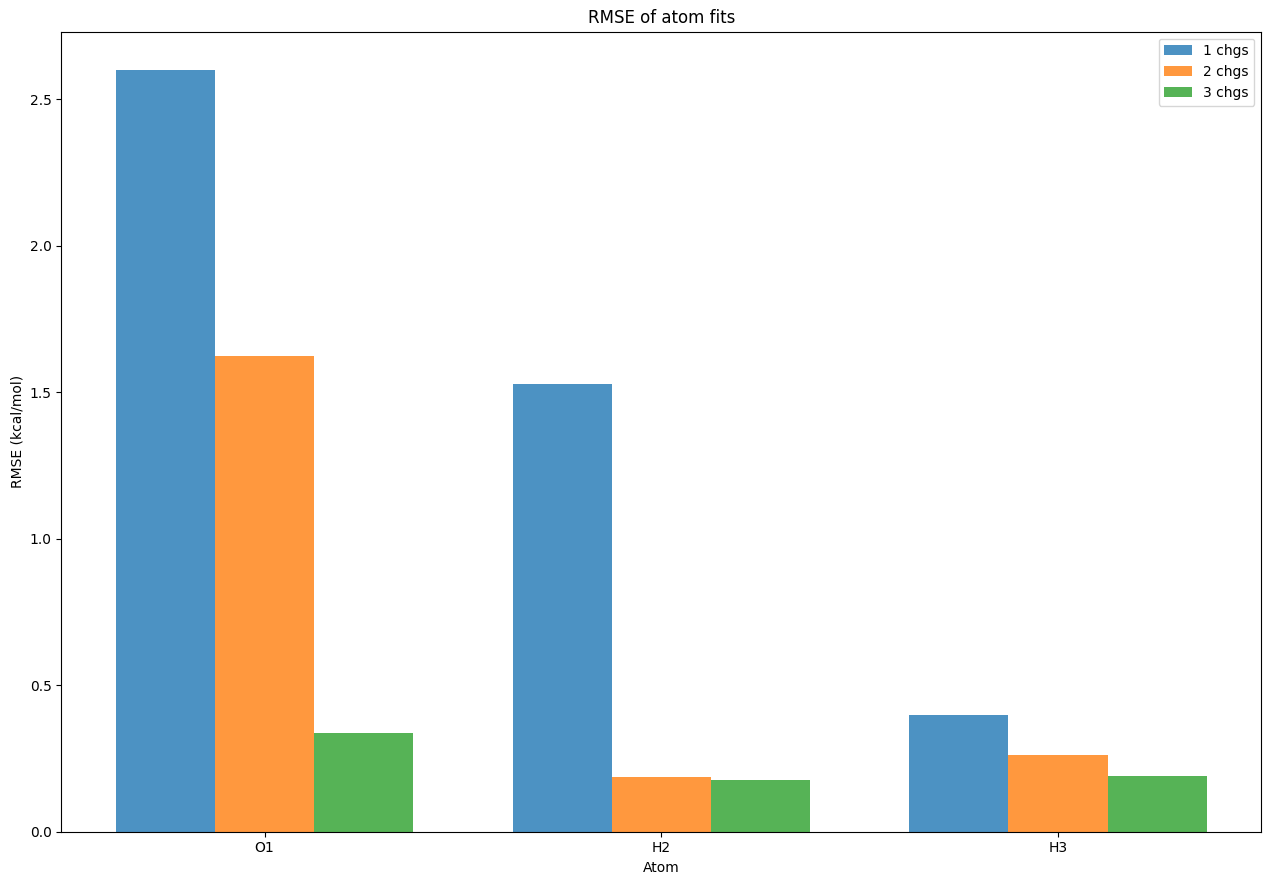

In [32]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import subprocess

# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Maximum number of charges to fit per atom (minimum is fixed at 1)
maxAChg=3

atomdir=workdir+'2-atomfit/'
Path(atomdir).mkdir(parents=True, exist_ok=True)

try:
    os.chdir(atomdir)
except FileNotFoundError:
    print("Could not change to atom fitting directory "+atomdir)
    raise FileNotFoundError

scripts=[]
jobid=[]
finished=[]
rmse=[]

for i in range(0,natm):
    jobid.append(0)
    finished.append(0)
    
for i in range(0,maxAChg):
    rmse.append([])
    for j in range(0,natm):
        rmse[i].append(0)
    
if os.path.isfile('jobIDs'):
    jf=open('jobIDs','r')
    for line in jf.readlines():
        a=line.split()
        jobid[int(a[0])-1]=int(a[1])
        
for i in range(1,natm+1):
    scripts.append('atom'+str(i)+'.sh')
    status=0 # 0=not started / crashed, 1=running, 2=finished
    # case 1: job is still running
    if jobid[i-1] != 0:
        status=1
        try:
            sout=subprocess.run(['squeue','-j',str(jobid[i-1])],stdout=subprocess.PIPE)
            if str(jobid[i-1]) not in sout.stdout.decode('utf-8').rstrip():
                status=0
        except subprocess.CalledProcessError as e:
            status=0
            raise subprocess.CalledProcessError
        if status == 1:
            print('Atom '+str(i)+': Job '+str(jobid[i-1])+' is still running')
    # case 2: output exists and job has finished or crashed
    if os.path.isfile(scripts[i-1]) and status==0:
        sf=open('atom'+str(i)+'-fit.out','r')
        for line in sf.readlines():
            a=line.split()
            if len(a) > 5:
                if a[0] == 'Best' and a[4] == str(maxAChg): # job finished and log file looks ok
                    status=2 # finished (probably...)
                    finished[i-1]=1
            for j in range(1,maxAChg+1):
                xyzfile='multipole'+str(i)+'_'+str(j)+'charges.xyz'
                if not os.path.isfile(xyzfile): # job finished, log file ok but somehow one or more xyz files are missing
                    status=0
                    print('Job '+str(jobid[i-1])+' has crashed, resubmitting')
        if status==0:
            print('Job '+str(jobid[i-1])+' has crashed, resubmitting')
            for j in range(1,maxAChg+1):
                rmfile='multipole'+str(i)+'_'+str(j)+'charges.xyz'
                sout=subprocess.run(['rm','-f',rmfile],stdout=subprocess.PIPE)
    if status != 0:
        continue
    # case 3: job has crashed or hasn't started
    sf=open(scripts[i-1],'w')
    sf.write('''#!/bin/bash
    
#SBATCH --job-name=atom%i
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --partition=%s

WORKDIR=%s
BINDIR=%s
MTPFILE=%s
PCUBE=%s
DCUBE=%s
NTRY=%i
ATOMINDEX=%i
MAXCHG=%i

cd $WORKDIR

srun $BINDIR/pcubefit.x -greedy $MTPFILE -esp $PCUBE -dens $DCUBE -nacmin 1 -nacmax $MAXCHG -atom $ATOMINDEX -ntry $NTRY -onlymultipoles -v > atom%i-fit.out
    ''' %(i,shortQ,atomdir,bindir,mtpfile,potCube,densCube,ntry,i,maxAChg,i))
    sf.close()
    sout=subprocess.run(['sbatch','--parsable',scripts[i-1]],stdout=subprocess.PIPE)
       
    jobid[i-1]=int(str(sout.stdout.decode('utf-8')).rstrip())
    print('submitted jobID '+str(jobid[i-1]))
    jf=open('jobIDs','a')
    jf.write(str(i)+' '+str(jobid[i-1])+'\n')
    jf.close()

# now show results for finished atoms
for i in range(1,natm+1):
    if finished[i-1] == 1:
        for j in range(1,maxAChg+1):
            xyzfile='multipole'+str(i)+'_'+str(j)+'charges.xyz'
            xf=open(xyzfile,'r')
            for line in xf.readlines():
                a=line.split()
                if len(a)==3:
                    if a[0] == 'RMSE':
                        rmse[j-1][i-1]=float(a[1])
            xf.close()

for i in range(0,maxAChg):
    print('\n## '+str(i+1)+'Charges Per Atom:')
    for j in range(0,natm):
        print('Atom '+ str(j+1)+' final RMSE: '+str(rmse[i][j])+' kcal/mol')

# Plot figure with Matplotlib
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
cols = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
labl = []
for i in range(0,natm):
    labl.append(coords[i][0]+str(i+1))
fig,ax = plt.subplots(figsize=(1200*px, 800*px))
X = np.arange(natm)
ax = fig.add_axes([0,0,1,1])
w = 1.0/(maxAChg+1)

for i in range(0,maxAChg):
    if i>9:
        col='tab:blue'
    else:
        col=cols[i]
    plt.bar(X+w*i, rmse[i], w,
        alpha=0.8,
        color=col,
        label=str(i+1)+' chgs')
    
plt.xlabel('Atom')
plt.ylabel('RMSE (kcal/mol)')
plt.xticks(X + w, labl)
plt.legend()
plt.title('RMSE of atom fits')

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False # Hide the Figure name at the top of the figure
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.canvas.capture_scroll = True
fig.canvas.toolbar_visible = True
display(fig) # display as png




## Step 4: Fit fragment charge models using atomic charge models from step 3

The atomic charge models can now be used to generate an initial population for Differential Evolution fitting of fragment charge models. You need to define the fragments using their atom indices at the top of the cell (the NGL window at the top of the notebook shows the molecular structure with the atom numbers). You should also define the maximum and minimum number of charges you'd like to try per fragment. Note that you can use less than one charge on average per fragment atom if you wish, but you can't use more than maxAChg charges per atom (see previous cell for maxAChg)

Job 38302513 has crashed, resubmitting
submitted jobID 38302555
Job 38302514 has crashed, resubmitting
submitted jobID 38302556
Job 38302515 has crashed, resubmitting
submitted jobID 38302557
Job 38302516 has crashed, resubmitting
submitted jobID 38302558
Job 38302517 has crashed, resubmitting
submitted jobID 38302559
Job 38302518 has crashed, resubmitting
submitted jobID 38302560

Summary of results:
Frag 1, Fit 1, 2 charges, RMSE: 1.621803338 kcal/mol
Frag 1, Fit 1, 3 charges, RMSE: 0.3383629706 kcal/mol
Frag 1, Fit 2, 2 charges, RMSE: 1.621803338 kcal/mol
Frag 1, Fit 2, 3 charges, RMSE: 0.3383629706 kcal/mol
Frag 2, Fit 1, 2 charges, RMSE: 0.1879262173 kcal/mol
Frag 2, Fit 1, 3 charges, RMSE: 0.1748970445 kcal/mol
Frag 2, Fit 2, 2 charges, RMSE: 0.1879262172 kcal/mol
Frag 2, Fit 2, 3 charges, RMSE: 0.1748970447 kcal/mol
Frag 3, Fit 1, 2 charges, RMSE: 0.2634483992 kcal/mol
Frag 3, Fit 1, 3 charges, RMSE: 0.1917743405 kcal/mol
Frag 3, Fit 2, 2 charges, RMSE: 0.2634483993 kcal/mol
Fra

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

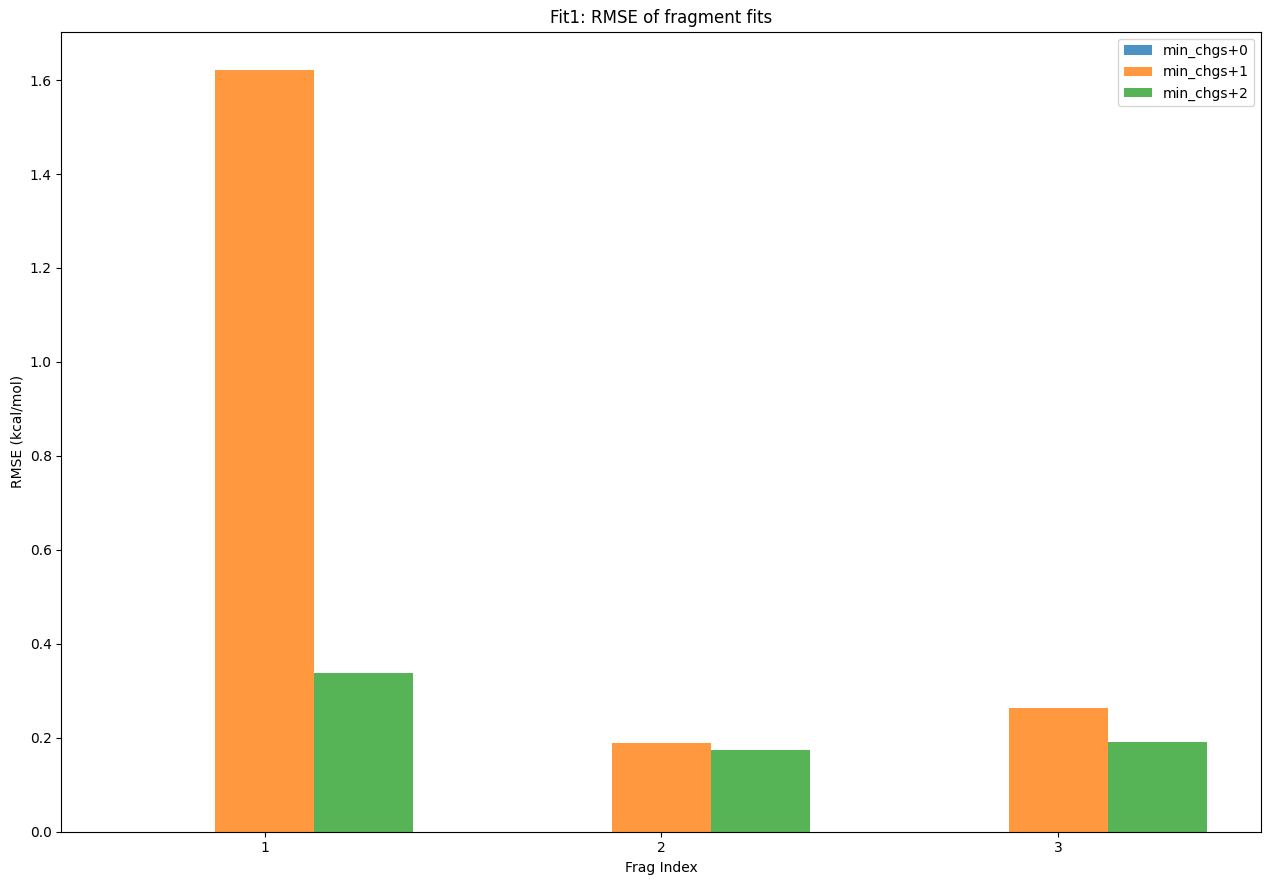

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

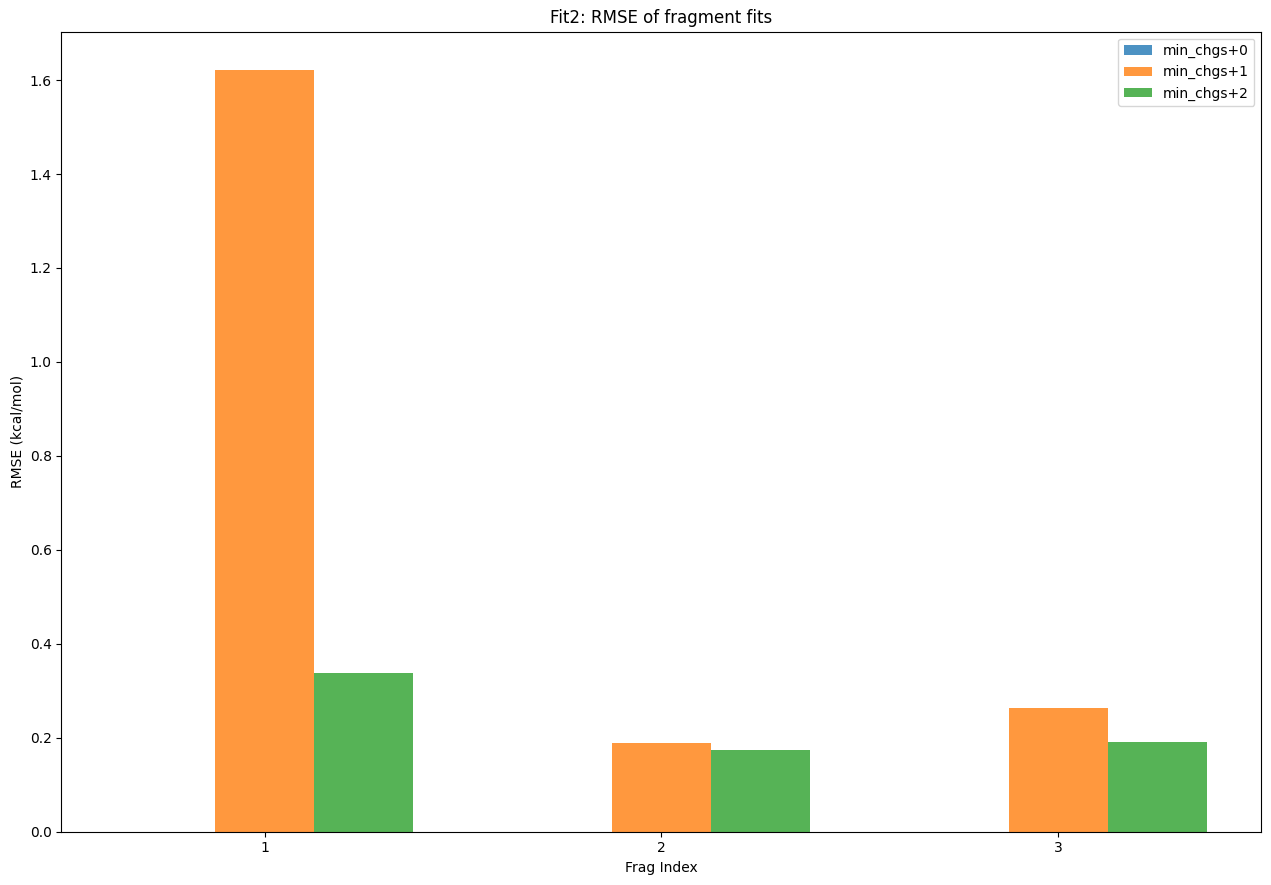

In [33]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import subprocess

# START OF USER VARIABLES
# START OF USER VARIABLES
# START OF USER VARIABLES
# START OF USER VARIABLES
# START OF USER VARIABLES



# Number of refinement iterations for each fit. More is better, but each fit will take longer
ntry=4
# Number of separate fits to perform (restarting a fit can lead to a better outcome). Cost scales linearly
nfit=2
# Define fragments using atom numbering from NGL window at top of notebook
#frags=[[1,3,4,5], [7,2], [6,9,10], [8, 11,12,13]]
frags=[[1], [2], [3]]

# Minimum number of charges to fit for each fragment (can average fewer than 1 per atom)
minFChg=[1,1,1]
# Maximum number of charges to fit for each fragment (upper limit per atom fixed by maxAChg)
maxFChg=[3,3,3]

# END OF USER VARIABLES

fragdir=workdir+'3-fragfit/'
Path(fragdir).mkdir(parents=True, exist_ok=True)
finished=[]

try:
    os.chdir(fragdir)
except FileNotFoundError:
    print("Could not change to fragment fitting directory "+fragdir)
    raise FileNotFoundError

# SUBMIT / MANAGE JOBS
for i in range(0,len(frags)):
    finished.append([])
    frag='frag'+str(i+1)
    Path(frag).mkdir(parents=True, exist_ok=True)
    try:
        os.chdir(frag)
    except FileNotFoundError:
        print("Could not change to fragment fitting directory "+frag)
        raise FileNotFoundError
    for j in range(0,nfit):
        finished[i].append([])
        Path('fit'+str(j+1)).mkdir(parents=True, exist_ok=True)
        fragstr=''
        for k in range(0,len(frags[i])-1):
            fragstr=fragstr+str(frags[i][k])+','
        fragstr=fragstr+str(frags[i][len(frags[i])-1])
        fitdir=fragdir+frag+'/'+'fit'+str(j+1)+'/'
        try:
            os.chdir(fitdir)
        except FileNotFoundError:
            print("Could not change to fragment fitting directory fit"+str(j+1))
            raise FileNotFoundError
        for k in range(0,natm):
            for l in range(0,maxAChg):
                tmp='multipole'+str(k+1)+'_'+str(l+1)+'charges.xyz'
                try:
                    copyfile(atomdir+tmp,fitdir+tmp)
                except:
                    print("Could not copy "+atomdir+tmp+" to "+fitdir)
                    raise FileNotFoundError
        jobid=[]
        for k in range(minFChg[i],maxFChg[i]+1):
            jobid.append(0)
            finished[i][j].append(0)
        if os.path.isfile('jobIDs'):
            jf=open('jobIDs','r')
            for line in jf.readlines():
                a=line.split()
                jobid[int(a[0])-1]=int(a[1])
            jf.close()
        for k in range(minFChg[i],maxFChg[i]+1):
            status=0 # 0=not started / crashed, 1=running, 2=finished
            # case 1: job is still running
            if jobid[k-minFChg[i]] != 0:
                status=1
                try:
                    sout=subprocess.run(['squeue','-j',str(jobid[k-minFChg[i]])],stdout=subprocess.PIPE)
                    if str(jobid[k-minFChg[i]]) not in sout.stdout.decode('utf-8').rstrip():
                        status=0
                except subprocess.CalledProcessError as e:
                    status=0
                if status == 1:
                    print('Frag '+str(i+1)+' fit '+str(j+1)+', '+str(k+1)+' charges: Job '+str(jobid[k-minFChg[i]])+' is still running') 
            # case 2: output exists and job has finished or crashed
            if os.path.isfile(str(k)+'chgs.sh') and status==0:
                sf=open(str(k)+'chgs.out','r')
                for line in sf.readlines():
                    a=line.split()
                    if len(a) > 5:
                        if a[0] == 'Best' and a[4] == str(k): # job finished and log file looks ok
                            status=2 # finished (probably...)
                            finished[i][j][k-minFChg[i]]=1
                xyzfile=str(k)+'charges.xyz'
                if not os.path.isfile(xyzfile): # job finished, log file ok but somehow one or more xyz files are missing
                    status=0
                if status==0:
                    print('Job '+str(jobid[k-minFChg[i]])+' has crashed, resubmitting')
                    rmfile=str(k)+'chgs.xyz'
                    sout=subprocess.run(['rm','-f',rmfile],stdout=subprocess.PIPE)
            if status != 0:
                continue
            # case 3: job has crashed or hasn't started
            f=open(str(k)+'chgs.sh','w')
            f.write('''#!/bin/bash

#SBATCH --job-name=frag%ifit%iq%i
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --partition=%s

WORKDIR=%s
BINDIR=%s
REFDIR=%s
MTPFILE=%s
PCUBE=%s
DCUBE=%s
NTRY=%i
ATOMLIST="%s"
MINCHG=%i
MAXCHG=%i
NAME="%ichgs"

cd $WORKDIR

srun $BINDIR/pcubefit.x -greedy $MTPFILE -esp $PCUBE -dens $DCUBE -ncmin $MINCHG -ncmax $MAXCHG -atom $ATOMLIST -nacmax %i -ntry $NTRY -v > $NAME".out"        
        ''' %(i+1,j+1,k,longQ,fragdir+frag+'/fit'+str(j+1),bindir,refdir,mtpfile,potCube,densCube,ntry,fragstr,k,k,k,maxAChg))
            f.close()
            
            sout=subprocess.run(['sbatch','--parsable', '{}chgs.sh'.format(k)],stdout=subprocess.PIPE)
#             print("printing stdout: ", sout, str(sout.stdout.decode('utf-8')))
            
            jobid[k-minFChg[i]]=int(str(sout.stdout.decode('utf-8')).rstrip())
            print('submitted jobID '+str(jobid[k-minFChg[i]]))
            jf=open('jobIDs','a')
            jf.write(str(k-minFChg[i]+1)+' '+str(jobid[k-minFChg[i]])+'\n')
            jf.close()
        os.chdir(fragdir+frag)
    os.chdir(fragdir)

# PROCESS RESULTS
os.chdir(fragdir)
rmse=[]
print('\nSummary of results:')
for i in range(0,len(frags)):
    rmse.append([])
    for j in range(0,nfit):
        rmse[i].append([])
        os.chdir(fragdir+"frag"+str(i+1)+"/fit"+str(j+1))
        for k in range(minFChg[i],maxFChg[i]+1):
            rmse[i][j].append(0.0)
            l=k-minFChg[i]
            if finished[i][j][l] == 1:
                xyzfile=str(k)+'charges.xyz'
                xf=open(xyzfile,'r')
                tmp='frag'+str(i+1)+'_fit'+str(j+1)+'_'+str(k)+'chgs.pdb'
                of=open(tmp,'w')
                of.write('REMARK: PDB GENERATED FROM '+xyzfile+'\n')
                ln=1
                for line in xf.readlines():
                    a=line.split()
                    if len(a)==3:
                        if a[0] == 'RMSE':
                            rmse[i][j][l]=float(a[1])
                    if ln>2 and ln<=k+2:
                        of.write('ATOM   %4i  %-3s MOL     1     %7.3f %7.3f %7.3f  1.00  0.00      MOL\n'
                                 %(ln-2,a[0],float(a[1]),float(a[2]),float(a[3])))
                    ln=ln+1
                xf.close()
                of.write('END')
                of.close()
                print("Frag "+str(i+1)+", Fit "+str(j+1)+", "+str(k)+" charges, RMSE: "+str(rmse[i][j][l])+" kcal/mol")

# PLOT FIGURES
# Plot figure(s) with Matplotlib - one for each fit
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
cols = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
labl = []
nfrag=len(frags)
nbin=0
for i in range(1,nfrag+1):
    labl.append(str(i))
    if (maxFChg[i-1]+1-minFChg[i-1]) > nbin:
        nbin=maxFChg[i]+1-minFChg[i]
for j in range(0,nfit):
    fig,ax = plt.subplots(figsize=(1200*px, 800*px))
    X = np.arange(nfrag)
    ax = fig.add_axes([0,0,1,1])
    w = 1.0/(nbin+1)

    for i in range(0,nbin):
        if i>9:
            col='tab:blue'
        else:
            col=cols[i]
        data=[]
        for k in range(0,nfrag):
            if i < (maxFChg[k]+1-minFChg[k]):
                data.append(rmse[k][j][i])
            else:
                data.append(0.0)
        plt.bar(X+w*i, data, w,
            alpha=0.8,
            color=col,
            label='min_chgs+'+str(i))
    
    plt.xlabel('Frag Index')
    plt.ylabel('RMSE (kcal/mol)')
    plt.xticks(X + w, labl)
    plt.legend()
    plt.title('Fit'+str(j+1)+': RMSE of fragment fits')

    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False # Hide the Figure name at the top of the figure
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    fig.canvas.capture_scroll = True
    fig.canvas.toolbar_visible = True
    display(fig) # display as png

# Show models in NGL
xyzfile='3-fragfit/frag1/fit1/frag1_fit1_'+str(minFChg[0])+'chgs.pdb'
f = open(htmldir+"fragXYZ.html", "w")
f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
<!--  <script src="https://unpkg.com/ngl"></script>-->
  <script>
    var xyzFile = 'http://localhost:%s/%s' 
    var pdbFile = 'http://localhost:%s/ref/%s'
  </script>
  <h3>NGL Visualization of Fragment Charge Models</h3>
  <h4>Fragments:</h4>
  ''' % (webPort,xyzfile,webPort,os.path.basename(pdbfile)))

f.write('<p>')
for i in range(0,nfrag):
    f.write('frag'+str(i+1)+' atoms: ')
    for j in range(0,len(frags[i])):
        f.write(str(frags[i][j])+' ')
    f.write('<br>')
f.write('</p>')

f.write('''
  <table><tr><td>Fragment ID</td><td>
  <input type="number" id="fragID" min="1" max="%i" step="1" value="1" onkeydown="return false" 
  onmouseup="setLimits(); loadXYZ()"></td></tr>
  <tr><td>Fit number</td><td>
  <input type="number" id="fitID" min="1" max="%i" step="1" value="1" onkeydown="return false" 
  onmouseup="loadXYZ()"></td></tr>
  <tr><td>No. of charges</td><td>
  <input type="number" id="nChg" min="%i" max="%i" step="1" value="%i" onkeydown="return false" 
  onmouseup="loadXYZ()"></td></tr>
  </table>
  <br>

  <table><tr><td>
  <p><div id="viewer"></div></p>
  </td></tr><tr><td>
  <div id="viewport" style="width:800px; height:800px;"></div>
  </td></tr></table>
  <script>
''' % (nfrag,nfit,minFChg[0],maxFChg[0],minFChg[0]));

f.write('      var minChgs=[')
for i in range(0,nfrag-1):
    f.write(str(minFChg[i])+',')
f.write(str(minFChg[nfrag-1])+'];\n')
f.write('      var maxChgs=[')
for i in range(0,nfrag-1):
    f.write(str(maxFChg[i])+',')
f.write(str(maxFChg[nfrag-1])+'];\n')
for i in range(0,nfrag):
    for j in range(0,nfit):
        f.write('      var rmse_'+str(i)+'_'+str(j)+'=[')
        for k in range(minFChg[i],maxFChg[i]):
            l=k-minFChg[i]
            f.write(str(rmse[i][j][l])+',')
        f.write(str(rmse[i][j][l+1])+'];\n')
    f.write('      var rmse_'+str(i)+'=[];\n')
    for j in range(0,nfit):
        f.write('      rmse_'+str(i)+'.push(rmse_'+str(i)+'_'+str(j)+');\n')
f.write('var rmse=[];')
for i in range(0,nfrag):
    f.write('      rmse.push(rmse_'+str(i)+');\n')

f.write('''
    document.addEventListener("DOMContentLoaded", function () {
        loadXYZ();
    } );
    function setLimits() {
        var input = document.getElementById("nChg");
        var frag = document.getElementById("fragID").value;
        input.setAttribute("max",maxChgs[frag-1]);
        input.setAttribute("min",minChgs[frag-1]); 
        input.value=minChgs[frag-1]
    }
    function loadXYZ() {
      var frag = document.getElementById("fragID").value;
      var fit = document.getElementById("fitID").value;
      var nChg = document.getElementById("nChg").value;
      var file = '3-fragfit/frag'+frag+'/fit'+fit+'/frag'+frag+'_fit'+fit+'_'+nChg+'chgs.pdb';
      document.getElementById("viewer").innerHTML = file+'<br>RMSE: '+rmse[frag-1][fit-1][nChg-minChgs[frag-1]].toFixed(3)+' kcal/mol';
      document.getElementById("viewport").innerHTML = "";
      xyzFile = 'http://localhost:%s/'+file

      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(pdbFile),
        stage.loadFile(xyzFile)
      ]).then(function(comp) {
        var pdbComp = comp[0]
        var xyzComp = comp[1]

        pdbComp.addRepresentation("line");
        pdbComp.addRepresentation("label",{labelType: "atomname",
                                        radius: "0.7",
                                           color: "cyan"});
        xyzComp.addRepresentation("spacefill",{radius: "0.1"});
        stage.autoView();
        } );
        
    }
  </script>
</body>
</html>
''' % (webPort)
)
f.close()

# generate a URL and open in an iframe
url = 'http://localhost:'+webPort+'/html/fragXYZ.html'
IPython.display.IFrame(src=url,width='1120',height='1250')

## Step 5: Combine fragments to build a molecular model

In this step for each desired total number of charges for the whole molecule, all possible permutations of the fragment models are combined to find the lowest RMSE. For example, if there are 2 fragments and we request 6 charges for the molecule then we can try 5 charges from fragment 1 and 1 charge from fragment 2, or 4 charges from fragment 1 and 2 charges from fragment 2 and so on. Note that the RMSE is just an estimate based on the individual RMSEs of the fragments.

In [34]:
minMChg=3
maxMChg=9

combdir = workdir+'4-combine/'
Path(combdir).mkdir(parents=True, exist_ok=True)

try:
    os.chdir(combdir)
except FileNotFoundError:
    print("Could not change to fragment combination directory "+combdir)
    raise FileNotFoundError

# Recursive routine to find all permutations of fragment models that provide the desired
# total number of charges
def findCombinationsUtil(arr, index, num,
                              reducedNum, nfrag, minfragchgs, maxfragchgs, pf):
    if (reducedNum < 0):
        return;

    if (reducedNum == 0):
        if(index == nfrag):
            # check that all solutions are within minchgs and maxchgs
            for i in range(index):
                if not (arr[i] >= minfragchgs[i] and arr[i] <= maxfragchgs[i]):
                    return;
            for i in range(index):
                pf.write(str(arr[i])+" ");
            pf.write("\n");
        return;

    if(index > nfrag): #discard solutions that require too many fragments
        return;

    # Find the previous number stored in arr[].  
    prev = 1 if(index == 0) else arr[index - 1];

    # note loop starts from previous number i.e. at array location index - 1 
    # for k in range(prev, num + 1): 
    for k in range(1, num + 1):
        arr[index] = k;
        # call recursively with reduced number 
        findCombinationsUtil(arr, index + 1, num,
                                 reducedNum - k, nfrag, minfragchgs, maxfragchgs, pf);


for i in range(minMChg,maxMChg+1):
    # array to store the combinations, it can contain max ncharges elements 
    arr = [0] * i;
    permFile='permutations-'+str(i)+'.dat'
    if os.path.isfile(permFile):
        continue
    pf=open(permFile,'w')
    findCombinationsUtil(arr,0,i,i,len(frags),minFChg,maxFChg,pf)
    pf.close()

script=bindir+"combine-frags.py"
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError
    
crmse=[]
for i in range(minMChg,maxMChg+1):
    crmse.append(0)
    print(str(i)+" CHARGES:")
    permFile='permutations-'+str(i)+'.dat'
    pf=open(permFile,'r')
    nperm=0
    nchg=[]
    bestRMSE=999999
    for line in pf:
        a=line.split()
        valid=1
        for j in range(0,len(a)):
            if int(a[j]) > (maxFChg[j]): 
                valid=0
        if valid == 0:
            continue
        best=[]
        fragFile=[]
        bestFRMSE=[]
        for j in range(0,len(a)):
            best.append(0)
            nchg.append(int(a[j]))
            bestFRMSE.append(99999)
            fragFile.append('')
            for k in range(0,nfit):
                trmse=rmse[j][k][int(a[j])-minFChg[j]]
                if trmse != 0 and trmse < bestFRMSE[j]:
                    bestFRMSE[j] = trmse
                    best[j] = k
                    fragFile[j] = fragdir+'frag'+str(j+1)+'/fit'+str(k+1)+'/'+str(int(a[j]))+'charges.xyz'
        meanRMSE=0
        fraglist=[]
        for j in range(0,len(a)):
            meanRMSE=meanRMSE+bestFRMSE[j]
            fraglist.append(fragFile[j])
        meanRMSE=meanRMSE/len(a)
        nperm=nperm+1
        
        
        if meanRMSE < bestRMSE:
            bestRMSE=meanRMSE
            print("NEW BEST "+str(i)+" charges: "+line.rstrip()+" rmse = "+str(meanRMSE))
            combFile=combdir+str(i)+"-combined.xyz"
            subprocess.run(['python',script]+fraglist, stdout=PIPE, stderr=PIPE)
            cf=open('combined.xyz',"a")
            cf.write("\ntotal molecule built from fragment files: ")
            for j in range(0,len(a)):
                cf.write(fraglist[j]+" ")
            cf.close()
            xyzfile=str(i)+'-combined.xyz'
            os.rename('combined.xyz',xyzfile)
            xf=open(xyzfile,'r')
            tmp=str(i)+'-combined.pdb'
            of=open(tmp,'w')
            of.write('REMARK: PDB GENERATED FROM '+xyzfile+'\n')
            ln=1
            for bline in xf.readlines():
                b=bline.split()
                if len(b)==3:
                    if b[0] == 'RMSE':
                        crmse[i-minMChg]=float(b[1])
                if ln>2 and ln<=i+2:
                    of.write('ATOM   %4i  %-3s MOL     1     %7.3f %7.3f %7.3f  1.00  0.00      MOL\n'
                                %(ln-2,b[0],float(b[1]),float(b[2]),float(b[3])))
                ln=ln+1
            xf.close()
            of.write('END')
            of.close()
    if nperm == 0:
        print("Could not satisfy "+str(i)+" charges with available fragments")
    

# Show models in NGL
xyzfile='4-combine/'+str(minMChg)+'-combined.pdb'
f = open(htmldir+"combXYZ.html", "w")
f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
<!--  <script src="https://unpkg.com/ngl"></script>-->
  <script>
    var xyzFile = 'http://localhost:%s/%s' 
    var pdbFile = 'http://localhost:%s/ref/%s'
  </script>
  <h3>NGL Visualization of Molecular Models Constructed from Fragments</h3>
  ''' % (webPort,xyzfile,webPort,os.path.basename(pdbfile)))

f.write('''
  <table><tr><td>No. of charges</td><td>
  <input type="number" id="nChg" min="%i" max="%i" step="1" value="%i" onkeydown="return false" 
  onmouseup="loadXYZ()"></td></tr>
  </table>
  <br>

  <table><tr><td>
  <p><div id="viewer"></div></p>
  </td></tr><tr><td>
  <div id="viewport" style="width:800px; height:800px;"></div>
  </td></tr></table>
  <script>
''' % (minMChg,maxMChg,minMChg));

f.write('''
    document.addEventListener("DOMContentLoaded", function () {
        loadXYZ();
    } );

    function loadXYZ() {
      var nChg = document.getElementById("nChg").value;
      var file = '4-combine/'+nChg+'-combined.pdb';
      document.getElementById("viewer").innerHTML = file /*+'<br>RMSE: '+rmse[frag-1][fit-1][nChg-minChgs[frag-1]].toFixed(3)+' kcal/mol';*/
      document.getElementById("viewport").innerHTML = "";
      xyzFile = 'http://localhost:%s/'+file

      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(pdbFile),
        stage.loadFile(xyzFile)
      ]).then(function(comp) {
        var pdbComp = comp[0]
        var xyzComp = comp[1]

        pdbComp.addRepresentation("line");
        pdbComp.addRepresentation("label",{labelType: "atomname",
                                        radius: "0.7",
                                           color: "cyan"});
        xyzComp.addRepresentation("spacefill",{radius: "0.1"});
        stage.autoView();
        } );
        
    }
  </script>
</body>
</html>
''' % (webPort)
)
f.close()

# generate a URL and open in an iframe
url = 'http://localhost:'+webPort+'/html/combXYZ.html'
IPython.display.IFrame(src=url,width='1120',height='1250')
        
    

3 CHARGES:
NEW BEST 3 charges: 1 1 1 rmse = 99999.0
4 CHARGES:
NEW BEST 4 charges: 1 1 2 rmse = 66666.08781613306
NEW BEST 4 charges: 1 2 1 rmse = 66666.0626420724
5 CHARGES:
NEW BEST 5 charges: 1 1 3 rmse = 66666.06392478016
NEW BEST 5 charges: 1 2 2 rmse = 33333.15045820547
6 CHARGES:
NEW BEST 6 charges: 1 2 3 rmse = 33333.12656685257
NEW BEST 6 charges: 2 2 2 rmse = 0.6910593181333334
7 CHARGES:
NEW BEST 7 charges: 1 3 3 rmse = 33333.122223795006
NEW BEST 7 charges: 2 2 3 rmse = 0.6671679652333333
NEW BEST 7 charges: 3 2 2 rmse = 0.26324586233333336
8 CHARGES:
NEW BEST 8 charges: 2 3 3 rmse = 0.6628249076666667
NEW BEST 8 charges: 3 2 3 rmse = 0.23935450943333333
9 CHARGES:
NEW BEST 9 charges: 3 3 3 rmse = 0.23501145186666664


## Step 6: Refine molecular models

In this step the molecular models produced by combining fragment MDCMs are refined in a final simplex opimization

3 charges: Job 38302561 is still running
4 charges: Job 38302562 is still running
5 charges: Job 38302563 is still running

Summary of results:
6 charges, RMSE: 0.66645482 kcal/mol
7 charges, RMSE: 0.2899873272 kcal/mol
8 charges, RMSE: 0.2951485085 kcal/mol
9 charges, RMSE: 0.2469059998 kcal/mol


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

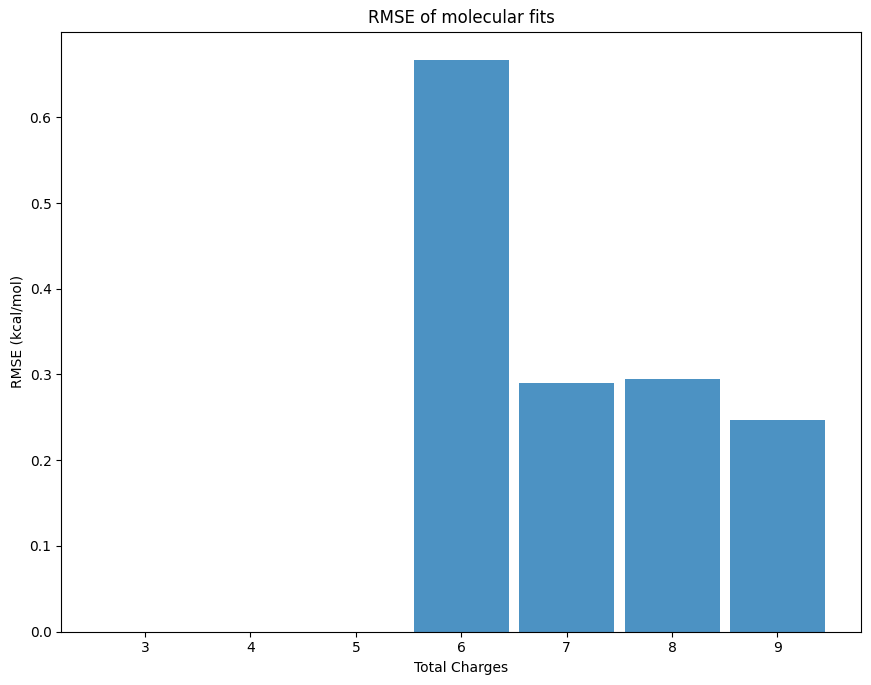

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

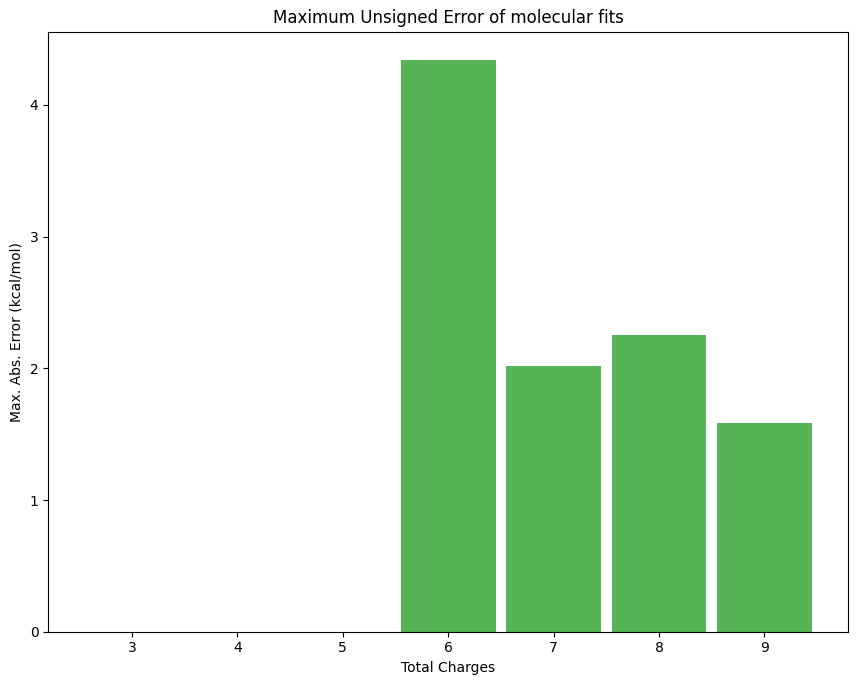

In [36]:
refinedir = workdir+'5-refine/'
Path(refinedir).mkdir(parents=True, exist_ok=True)

MINNTRY=1      #tries for largest number of charges (DE only)
MAXNTRY=1      #tries for smallest number of charges (DE only)

qrange=maxMChg - minMChg + 1
tryrange=MAXNTRY - MINNTRY

try:
    os.chdir(refinedir)
except FileNotFoundError:
    print("Could not change to molecular refinement directory "+refinedir)
    raise FileNotFoundError

jobid=[]
for i in range(minMChg,maxMChg+1):
    jobid.append(0)
if os.path.isfile('jobIDs'):
    jf=open('jobIDs','r')
    for line in jf.readlines():
        a=line.split()
        jobid[int(a[0])-1]=int(a[1])
    jf.close()

finished=[]
for i in range(minMChg,maxMChg+1):
    finished.append(0)
    xyzfile=combdir+str(i)+'-combined.xyz'
    subdir=refinedir+str(i)+"-charges/"
    if not os.path.isfile(xyzfile):
        print("No model with "+str(i)+"charges exists in "+combdir)
        continue
    status=0 # 0=not started / crashed, 1=running, 2=finished
    # case 1: job is still running
    if jobid[i-minMChg] != 0:
        status=1
        try:
            sout=subprocess.run(['squeue','-j',str(jobid[i-minMChg])],stdout=subprocess.PIPE)
            if str(jobid[i-minMChg]) not in sout.stdout.decode('utf-8').rstrip():
                status=0
        except subprocess.CalledProcessError as e:
            status=0
            raise subprocess.CalledProcessError
        if status == 1:
            print(str(i)+' charges: Job '+str(jobid[i-minMChg])+' is still running')
        # case 2: output exists and job has finished or crashed
        if os.path.isfile(subdir+str(i)+'-charges.sh') and status==0:
            sf=open(subdir+str(i)+'-charges.out','r')
            for line in sf.readlines():
                a=line.split()
                if len(a) > 5:
                    if a[0] == 'Best' and a[4] == str(i): # job finished and log file looks ok
                        status=2 # finished (probably...)
                        finished[i-minMChg]=1
            xyzfile=subdir+str(i)+'_charges_refined.xyz'
            if not os.path.isfile(xyzfile): # job finished, log file ok but somehow one or more xyz files are missing
                status=0
            if status==0:
                print('Job '+str(jobid[i-minMChg])+' has crashed, resubmitting')
                rmfile=subdir+str(i)+'_charges_refined.xyz'
                sout=subprocess.run(['rm','-f',rmfile],stdout=subprocess.PIPE)
    if status!=0:
        continue
    # calculate NTRY for this molecule (linear decrease with increasing number of charges)
    if minMChg == maxMChg:  #avoid divide by zero
        ntry=MAXNTRY
    else:
        tmp=i-minMChg
        tmp=MAXNTRY - tryrange*tmp / qrange
        ntry=int(tmp)
    Path(subdir).mkdir(parents=True, exist_ok=True)
    subfile=subdir+str(i)+"-charges.sh"
    sf=open(subfile,"w")
    sf.write('''#!/bin/bash

#SBATCH --job-name=refine-%ichg
#SBATCH --nodes=1
#SBATCH --ntasks=4
#SBATCH --partition=%s

cd %s

%s/pcubefit.x -xyz %s %s -simplex -esp %s -dens %s -nacmax %i -ntry %i -v > %i-charges.out
    ''' %(i,longQ,subdir,bindir,xyzfile,mtpfile,potCube,densCube,maxAChg,ntry,i))
    sf.close()
    sout=subprocess.run(['sbatch','--parsable',subfile],stdout=subprocess.PIPE)
    jobid[i-minMChg]=int(str(sout.stdout.decode('utf-8')).rstrip())
    print('submitted jobID '+str(jobid[i-minMChg]))
    jf=open('jobIDs','a')
    jf.write(str(i-minMChg+1)+' '+str(jobid[i-minMChg])+'\n')
    jf.close()
    
# PROCESS RESULTS
rmse=[]
mae=[]
emax=[]
print('\nSummary of results:')
for i in range(minMChg,maxMChg+1):
    subdir=refinedir+str(i)+"-charges/"
    rmse.append(0.0)
    mae.append(0.0)
    emax.append(0.0)
    l=i-minMChg
    if finished[l] == 1:
        xyzfile=subdir+str(i)+'_charges_refined.xyz'
        xf=open(xyzfile,'r')
        tmp=subdir+str(i)+'-charges.pdb'
        of=open(tmp,'w')
        of.write('REMARK: PDB GENERATED FROM '+xyzfile+'\n')
        ln=1
        for line in xf.readlines():
            a=line.split()
            if len(a)==3:
                if a[0] == 'RMSE':
                    rmse[l]=float(a[1])
                if a[0] == 'MAE':
                    mae[l]=float(a[1])
            if len(a)==4:
                if a[0] == 'max.':
                    emax[l]=float(a[2])
            if ln>2 and ln<=i+2:
                of.write('ATOM   %4i  %-3s MOL     1     %7.3f %7.3f %7.3f  1.00  0.00      MOL\n'
                            %(ln-2,a[0],float(a[1]),float(a[2]),float(a[3])))
            ln=ln+1
        xf.close()
        of.write('END')
        of.close()
        print(str(i)+" charges, RMSE: "+str(rmse[l])+" kcal/mol")

# PLOT FIGURES
# Plot RMSEs with Matplotlib
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
cols = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
labl = []
for i in range(minMChg,maxMChg+1):
    labl.append(str(i))

fig,ax = plt.subplots(figsize=(800*px, 600*px))
X = np.arange(qrange)
ax = fig.add_axes([0,0,1,1])
w = 0.9
col='tab:blue'
data=[]
for i in range(0,qrange):
    data.append(rmse[i])
plt.bar(X, data, w,
    alpha=0.8,
    color=col)
    
plt.xlabel('Total Charges')
plt.ylabel('RMSE (kcal/mol)')
plt.xticks(X , labl)
plt.title('RMSE of molecular fits')

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False # Hide the Figure name at the top of the figure
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.canvas.capture_scroll = True
fig.canvas.toolbar_visible = True
display(fig) # display as png

# Plot max. errors
fig2,ax2 = plt.subplots(figsize=(800*px, 600*px))
ax3 = fig2.add_axes([0,0,1,1])
col2='tab:green'
data2=[]
for i in range(0,qrange):
    data2.append(emax[i])
plt.bar(X, data2, w,
    alpha=0.8,
    color=col2)
    
plt.xlabel('Total Charges')
plt.ylabel('Max. Abs. Error (kcal/mol)')
plt.xticks(X , labl)
plt.title('Maximum Unsigned Error of molecular fits')

fig2.canvas.toolbar_visible = False
fig2.canvas.header_visible = False # Hide the Figure name at the top of the figure
fig2.canvas.footer_visible = False
fig2.canvas.resizable = False
fig2.canvas.capture_scroll = True
fig2.canvas.toolbar_visible = True
display(fig2) # display as png

# Show models in NGL
xyzfile='5-refine/'+str(minMChg)+'-charges/'+str(minMChg)+'-charges.pdb'
f = open(htmldir+"refinedXYZ.html", "w")
f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
<!--  <script src="https://unpkg.com/ngl"></script>-->
  <script>
    var xyzFile = 'http://localhost:%s/%s' 
    var pdbFile = 'http://localhost:%s/ref/%s'
  </script>
  <h3>NGL Visualization of Molecular Models Constructed from Fragments</h3>
  ''' % (webPort,xyzfile,webPort,os.path.basename(pdbfile)))

f.write('''
  <table><tr><td>No. of charges</td><td>
  <input type="number" id="nChg" min="%i" max="%i" step="1" value="%i" onkeydown="return false" 
  onmouseup="loadXYZ()"></td></tr>
  </table>
  <br>

  <table><tr><td>
  <p><div id="viewer"></div></p>
  </td></tr><tr><td>
  <div id="viewport" style="width:800px; height:800px;"></div>
  </td></tr></table>
  <script>
      var minChgs=%s;
''' % (minMChg,maxMChg,minMChg,minMChg));

f.write('      var rmse=[')
for i in range(0,qrange-2):
    f.write(str(rmse[i])+',')
f.write(str(rmse[qrange-1])+'];\n')

f.write('''
    document.addEventListener("DOMContentLoaded", function () {
        loadXYZ();
    } );

    function loadXYZ() {
      var nChg = document.getElementById("nChg").value;
      var file = '5-refine/'+nChg+'-charges/'+nChg+'-charges.pdb';
      document.getElementById("viewer").innerHTML = file +'<br>RMSE: '+rmse[nChg-minChgs].toFixed(3)+' kcal/mol';
      document.getElementById("viewport").innerHTML = "";
      xyzFile = 'http://localhost:%s/'+file

      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(pdbFile),
        stage.loadFile(xyzFile)
      ]).then(function(comp) {
        var pdbComp = comp[0]
        var xyzComp = comp[1]

        pdbComp.addRepresentation("line");
        pdbComp.addRepresentation("label",{labelType: "atomname",
                                        radius: "0.7",
                                           color: "cyan"});
        xyzComp.addRepresentation("spacefill",{radius: "0.1"});
        stage.autoView();
        } );
        
    }
  </script>
</body>
</html>
''' % (webPort)
)
f.close()

# generate a URL and open in an iframe
url = 'http://localhost:'+webPort+'/html/refinedXYZ.html'
IPython.display.IFrame(src=url,width='1120',height='1050')


## Step 6: Analysis

In this step individual models can be examined in detail in terms of their performance compared to different multipole models with visualization of the ESP surface.

In [17]:
# USER-DEFINED VARIABLES
# The charge model to be analyzed:
nchg=8
#

anadir=workdir+'6-analysis/'
Path(anadir).mkdir(parents=True, exist_ok=True)

try:
    os.chdir(anadir)
except FileNotFoundError:
    print("Could not change to model analysis directory "+anadir)
    raise FileNotFoundError

xyzfile=refinedir+str(nchg)+'-charges/'+str(nchg)+'_charges_refined.xyz'
try:
    af=open(xyzfile,'r')
except FileNotFoundError:
    print("\nNo model found with "+str(nchg)+' charges: file '+xyzfile+' is missing\n')
    raise FileNotFoundError

rmse=[]
maxErr=[]
npts=[]
logFile=open(mtpdir+'analyze-mtpl-cube.log','r')
for line in logFile:
    a=line.split()
    if len(a) > 3: 
        if a[0] == 'Total':
            rmse.append(float(a[1]))
            maxErr.append(float(a[2]))
            npts.append(int(a[3]))
            print("Ditriantapole RMSE: "+a[1])
        if a[0] == 'Close':
            rmse.append(float(a[8]))
            maxErr.append(float(a[9]))
            npts.append(int(a[10]))
        if a[0] == 'Mid-range':
            rmse.append(float(a[7]))
            maxErr.append(float(a[8]))
            npts.append(int(a[9]))
        if a[0] == 'Far-range':
            rmse.append(float(a[5]))
            maxErr.append(float(a[6]))
            npts.append(int(a[7]))
logFile.close()  

print(rmse[-1])


# Fit reference atom-centered charge and qaudrupole models for comparison
chgdir=anadir+'charge-fit/'
Path(chgdir).mkdir(parents=True, exist_ok=True)
try:
    os.chdir(chgdir)
except FileNotFoundError:
    print("Could not change to least-squares charge fitting directory "+chgdir)
    raise FileNotFoundError

script=bindir+"mtpfit.py"
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError

# Run Least-Squares fit of atomic multipoles to ESP in reference cube file
chgfile=chgdir+'fitted-mtpl.dat'
if not os.path.isfile(chgfile):
    subprocess.run(['python',script,'-pot',potCube,'-dens',densCube,'-lmax','0','-qtot',str(qtot)], stdout=PIPE, stderr=PIPE)

# Generate a cube file to visualize the monopolar ESP and compare to the reference ESP
script=bindir+'pcubefit.x'
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError
if not os.path.isfile('monopole_expansion.cube'):
    logFile=open('fitted-chg-cube.log','w')
    errFile=open('errlog','w')
    subprocess.run([script,'-v','-generate','-multipole','-esp',potCube,
                    '-dens',densCube,'-xyz',chgfile],stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()
    
# Analyze monopolar ESP cube file to get statistics (RMSE of fit etc.)
if not os.path.isfile('analyze-chg-cube.log'):
    logFile=open('analyze-chg-cube.log','w')
    errFile=open('errlog2','w')
    subprocess.run([script,'-v','-analysis','-esp',potCube,'-esp2',
                    'monopole_expansion.cube','-dens',densCube],stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()

logFile=open('analyze-chg-cube.log','r')
for line in logFile:
    a=line.split()
    if len(a) > 3: 
        if a[0] == 'Total':
            rmse.append(float(a[1]))
            maxErr.append(float(a[2]))
            npts.append(int(a[3]))
            print("Monopole RMSE: "+a[1])
        if a[0] == 'Close':
            rmse.append(float(a[8]))
            maxErr.append(float(a[9]))
            npts.append(int(a[10]))
        if a[0] == 'Mid-range':
            rmse.append(float(a[7]))
            maxErr.append(float(a[8]))
            npts.append(int(a[9]))
        if a[0] == 'Far-range':
            rmse.append(float(a[5]))
            maxErr.append(float(a[6]))
            npts.append(int(a[7]))
logFile.close()    

print(rmse[-1])


os.chdir(anadir)
quaddir=anadir+"quad-fit/"
Path(quaddir).mkdir(parents=True, exist_ok=True)
try:
    os.chdir(quaddir)
except FileNotFoundError:
    print("Could not change to least-squares quadrupole fitting directory "+quaddir)
    raise FileNotFoundError
    
# Run Least-Squares fit of atomic multipoles to ESP in reference cube file
script=bindir+"mtpfit.py"
quadfile=quaddir+'fitted-mtpl.dat'
if not os.path.isfile(quadfile):
    print("satisfied")
    logFile=open('python-fitted-quad-cube.log','w')
    errFile=open('python-errlog','w')
    subprocess.run(['python',script,'-pot',potCube,'-dens',
                    densCube,'-lmax','2','-qtot',str(qtot)], stdout=logFile, stderr=errFile)  

# Generate a cube file to visualize the quadrupolar ESP and compare to the reference ESP
script=bindir+'pcubefit.x'
if not os.path.isfile(script):
    print("Error: could not open "+script)
    raise FileNotFoundError
if not os.path.isfile('quadrupole_expansion.cube'):
    logFile=open('fitted-quad-cube.log','w')
    errFile=open('errlog','w')
    subprocess.run([script,'-v','-generate','-multipole','-esp',potCube,'-dens',densCube,'-xyz',quadfile],
                   stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()    

# Analyze quadrupolar ESP cube file to get statistics (RMSE of fit etc.)
if not os.path.isfile('analyze-quad-cube.log'):
    logFile=open('analyze-quad-cube.log','w')
    errFile=open('errlog2','w')
    subprocess.run([script,'-v','-analysis','-esp',potCube,'-esp2','quadrupole_expansion.cube','-dens',densCube],
                   stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()
    
logFile=open('analyze-quad-cube.log','r')
for line in logFile:
    a=line.split()
    if len(a) > 3: 
        if a[0] == 'Total':
            rmse.append(float(a[1]))
            maxErr.append(float(a[2]))
            npts.append(int(a[3]))
            print("Quadrupole RMSE: "+a[1])
        if a[0] == 'Close':
            rmse.append(float(a[8]))
            maxErr.append(float(a[9]))
            npts.append(int(a[10]))
        if a[0] == 'Mid-range':
            rmse.append(float(a[7]))
            maxErr.append(float(a[8]))
            npts.append(int(a[9]))
        if a[0] == 'Far-range':
            rmse.append(float(a[5]))
            maxErr.append(float(a[6]))
            npts.append(int(a[7]))
logFile.close()

print(rmse[-1])


# Generate a cube file for the newly fitted MDCM for comparison
os.chdir(anadir)
moldir=str(nchg)+"-charges/"
Path(moldir).mkdir(parents=True, exist_ok=True)
try:
    os.chdir(moldir)
except FileNotFoundError:
    print("Could not change to MDCM analysis directory "+moldir)
    raise FileNotFoundError

if not os.path.isfile(str(nchg)+'charges.cube'):
    logFile=open(str(nchg)+'-cube.log','w')
    errFile=open('errlog','w')
    subprocess.run([script,'-v','-generate','-esp',potCube,'-dens',densCube,'-xyz',xyzfile],stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()  

# Generate slices showing errors in R for MDCM fit
rLogFile=open('rLog','w')
rErrFile=open('rErrlog','w')
script2=bindir+'visualize.r'
if not os.path.isfile(script2):
    print("Error: could not open "+script2)
    raise FileNotFoundError
if not os.path.isfile('comparison.png'):
    subprocess.run([script2],stdout=rLogFile,stderr=rErrFile)
    
# Analyze generated ESP cube file to get statistics (RMSE of fit etc.)
if not os.path.isfile('analyze-mdcm-cube.log'):
    logFile=open('analyze-mdcm-cube.log','w')
    errFile=open('errlog2','w')
    subprocess.run([script,'-v','-analysis','-esp',potCube,'-esp2',str(nchg)+'charges.cube','-dens',densCube],
                   stdout=logFile,stderr=errFile)
    logFile.close()
    errFile.close()
    
logFile=open('analyze-mdcm-cube.log','r')
for line in logFile:
    a=line.split()
    if len(a) > 3: 
        if a[0] == 'Total':
            rmse.append(float(a[1]))
            maxErr.append(float(a[2]))
            npts.append(int(a[3]))
            print(str(nchg)+" charge model RMSE: "+a[1])
        if a[0] == 'Close':
            rmse.append(float(a[8]))
            maxErr.append(float(a[9]))
            npts.append(int(a[10]))
        if a[0] == 'Mid-range':
            rmse.append(float(a[7]))
            maxErr.append(float(a[8]))
            npts.append(int(a[9]))
        if a[0] == 'Far-range':
            rmse.append(float(a[5]))
            maxErr.append(float(a[6]))
            npts.append(int(a[7]))
logFile.close()
print(rmse[-1])

# Now create a function to generate HTML to compare two ESP surfaces
cubeFiles=['ref/'+os.path.basename(potCube),'1-mtpfit/ditriantapole_expansion.cube',
           '6-analysis/charge-fit/monopole_expansion.cube','6-analysis/quad-fit/quadrupole_expansion.cube',
           '6-analysis/'+str(nchg)+'-charges/'+str(nchg)+'charges.cube']
errorFiles=['1-mtpfit/error.cube','6-analysis/charge-fit/error.cube','6-analysis/quad-fit/error.cube',
            '6-analysis/'+str(nchg)+'-charges/error.cube']

def writeNGLHTML2(htmlF,densF1,potF1,densF2,potF2,rmse,maxErr,npts,imgFile):
    f = open(htmldir+htmlF, "w")
    f.write('''
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="utf-8">
</head>
<body>
  <script src="https://prakt.chemie.unibas.ch/~devereux/ngl-master/dist/ngl.js"></script>
<!--  <script src="https://unpkg.com/ngl"></script>-->
  <script>
    var c1=0;
    var c2=4;
''')

    f.write('    var cubes=[')
    for i in range(0,len(cubeFiles)):
        f.write("'"+cubeFiles[i]+"',")
    for i in range(0,len(errorFiles)-1):
        f.write("'"+errorFiles[i]+"',")
    f.write("'"+errorFiles[len(errorFiles)-1]+"'];\n")
    f.write('    var maxESP=[')
    for i in range(0,len(cubeFiles)):
        f.write(str(maxESP)+',')
    for i in range(0,len(errorFiles)-1):
        f.write(str(maxErr[i*4] / 627)+',')
    f.write(str(maxErr[4*(len(errorFiles)-1)] / 627)+'];\n')
    
    f.write('''
    var densFile = 'http://localhost:%s/%s';
    var espFile = '';
    
    document.addEventListener("DOMContentLoaded", function () {
        loadCube1(0);
        loadCube2(4);
    } );
    
    function loadCube1(c1){
      espFile = 'http://localhost:%s/'+cubes[c1];
      document.getElementById("viewport").innerHTML = "";
      document.getElementById("caption").innerHTML = '<p>'+cubes[c1]+'<br>range: red -'+(maxESP[c1]*627).toFixed(2)+
          ' to blue '+(maxESP[c1]*627).toFixed(2)+' kcal/mol</p>';
      var stage = new NGL.Stage("viewport");

      Promise.all([
        stage.loadFile(densFile),
        stage.loadFile(espFile)
      ]).then(function(comp) {
        var densComp = comp[0]
        var espComp = comp[1]


        densComp.addRepresentation("surface",{isolevel: "%8.4f",
                                              isolevelType: 'value',
                                              opacity: 0.95,
                                              side: 'front',
                                              colorScheme: 'volume',
                                              colorVolume: espComp.volume,
                                              colorScale: [ 0xff0000, 0xffff00, 0x00ff00, 0x00ffff, 0x0000ff ],
                                              colorMode: 'rgb',
                                              colorDomain: [ -maxESP[c1], maxESP[c1] ]
                                              });
        stage.autoView();
        stage.viewerControls.zoom(-0.5);
      } );
    };

    var densFile2 = 'http://localhost:%s/%s';
    var espFile2= '';

    function loadCube2(c2){
      document.getElementById("viewport2").innerHTML = "";
      document.getElementById("caption2").innerHTML = '<p>'+cubes[c1]+'<br>range: red -'+(maxESP[c2]*627).toFixed(2)+
          ' to blue '+(maxESP[c2]*627).toFixed(2)+' kcal/mol</p>';
      var stage2 = new NGL.Stage("viewport2");
      espFile2 = 'http://localhost:%s/'+cubes[c2];

      Promise.all([
        stage2.loadFile(densFile2),
        stage2.loadFile(espFile2)
      ]).then(function(comp2) {
        var densComp2 = comp2[0]
        var espComp2 = comp2[1]


        densComp2.addRepresentation("surface",{isolevel: "%8.4f",
                                              isolevelType: 'value',
                                              opacity: 0.95,
                                              side: 'front',
                                              colorScheme: 'volume',
                                              colorVolume: espComp2.volume,
                                              colorScale: [ 0xff0000, 0xffff00, 0x00ff00, 0x00ffff, 0x0000ff ],
                                              colorMode: 'rgb',
                                              colorDomain: [ -maxESP[c2], maxESP[c2] ]
                                              });
        stage2.autoView();
        stage2.viewerControls.zoom(-0.5);
      } );
    };
  </script>
  <h3>NGL Cube File Visualization</h3>
  <table><tr><td><h3>Left Pane</h3></td><td><h3>Right Pane</h3></td></tr><tr><td>
  ''' %(webPort,densF1,webPort,isoSurf,webPort,densF2,webPort,isoSurf))

    for i in range(0,len(cubeFiles)):
        f.write('    <input type="radio" id="cube1_%i" name="cubeF1" value="%i" onclick="loadCube1(%i);"' %(i,i,i))
        if i == 0:
            f.write('checked="checked"')
        f.write('>\n    <label for="cube1_%i">%s</label><br>\n''' %(i,cubeFiles[i]))
    for i in range(0,len(errorFiles)):
        t=len(cubeFiles)
        f.write('    <input type="radio" id="cube1_%i" name="cubeF1" value="%i" onclick="loadCube1(%i);"' %(i+t,i+t,i+t))
        f.write('>\n    <label for="cube1_%i">%s</label><br>\n''' %(i+5,errorFiles[i]))
    f.write('\n    </td><td>\n')
    for i in range(0,len(cubeFiles)):
        f.write('    <input type="radio" id="cube2_%i" name="cubeF2" value="%i" onclick="loadCube2(%i);"' %(i,i,i))
        if i == 4:
            f.write('checked="checked"')
        f.write('>\n    <label for="cube2_%i">%s</label><br>\n''' %(i,cubeFiles[i]))
    for i in range(0,len(errorFiles)):
        t=len(cubeFiles)
        f.write('    <input type="radio" id="cube2_%i" name="cubeF2" value="%i" onclick="loadCube2(%i);"' %(i+t,i+t,i+t))
        f.write('>\n    <label for="cube2_%i">%s</label><br>\n''' %(i+5,errorFiles[i]))
        
    f.write('''
  </td></tr></table>
  <table><tr><td>
  <div id="viewport" style="width:500px; height:500px;"></div><div id="caption"></div>
  </td><td>
  <div id="viewport2" style="width:500px; height:500px;"></div><div id="caption2"></div>
  </td></tr></table>
  <h3>Fitted MDCM Performance Compared to Reference ESP:</h3>
  <table cellpadding="5">
  <tr><td><b>Measure</b></td><td><b>RMSE[kcal/mol/e]</b></td><td><b>MaxError[kcal/mol/e]</b></td><td><b>NPoints</b></td></tr>
  <tr><td><b>Total                        </b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Close  (  1.20 < r <   1.66 )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Mid-range ( 1.66 < r <  2.20)</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Far-range ( 2.20 < r        )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  </table>
  <h3>Fitted Quadrupole Model Performance (for comparison):</h3>
  <table cellpadding="5">
  <tr><td><b>Measure</b></td><td><b>RMSE[kcal/mol/e]</b></td><td><b>MaxError[kcal/mol/e]</b></td><td><b>NPoints</b></td></tr>
  <tr><td><b>Total                        </b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Close  (  1.20 < r <   1.66 )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Mid-range ( 1.66 < r <  2.20)</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Far-range ( 2.20 < r        )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  </table>
  <h3>Fitted Central-Charge Model Performance (for comparison):</h3>
  <table cellpadding="5">
  <tr><td><b>Measure</b></td><td><b>RMSE[kcal/mol/e]</b></td><td><b>MaxError[kcal/mol/e]</b></td><td><b>NPoints</b></td></tr>
  <tr><td><b>Total                        </b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Close  (  1.20 < r <   1.66 )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Mid-range ( 1.66 < r <  2.20)</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  <tr><td><b>Far-range ( 2.20 < r        )</b></td><td>%7.3f</td><td>%7.3f</td><td>%i</td></tr>
  </table>
  <h2><br>ESP Slice Data (ESP and Errors in each plane)<br></h2>
  <img src="http://localhost:%s/%s" alt="Slice Data" style="width:1020px;">
</body>
</html>
''' % (rmse[12],maxErr[12],npts[12],rmse[13],maxErr[13],npts[13],rmse[14],maxErr[14],npts[14],rmse[15],maxErr[15],npts[15],
       rmse[8],maxErr[8],npts[8],rmse[9],maxErr[9],npts[9],rmse[10],maxErr[10],npts[10],rmse[11],maxErr[11],npts[11],
       rmse[4],maxErr[4],npts[4],rmse[5],maxErr[5],npts[5],rmse[6],maxErr[6],npts[6],rmse[7],maxErr[7],npts[7],
       webPort,imgFile)
    )
    f.close()

# PLOT FIGURES
# Plot RMSEs with Matplotlib
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
cols = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
labl = ['Total','Close','Mid-range','Far-range']
labl2 = ['Central Chgs','Quadrupoles','MDCM '+str(nchg)+' Chgs']
nbin=3

fig,ax = plt.subplots(figsize=(800*px, 600*px))
X = np.arange(4)
ax = fig.add_axes([0,0,1,1])
w = 1.0/(nbin+1)
print(rmse)
for i in range(0,nbin):
    if i>9:
        col='tab:blue'
    else:
        col=cols[i]
    data=[]
    
    for j in range(0,4):
        data.append(rmse[4+4*i+j])
    
    plt.bar(X+w*i, data, w,
        alpha=0.8,
        color=col,
        label=labl2[i])
    
plt.xlabel('Model & Spatial Region')
plt.ylabel('RMSE (kcal/mol)')
plt.xticks(X , labl)
plt.legend()
plt.title('RMSE of molecular fits')

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False # Hide the Figure name at the top of the figure
fig.canvas.footer_visible = False
fig.canvas.resizable = False
fig.canvas.capture_scroll = True
fig.canvas.toolbar_visible = True
display(fig) # display as png

# SHOW SLICES FROM R
writeNGLHTML2('analyze.html','ref/'+os.path.basename(densCube),errorFiles[2],'ref/'+os.path.basename(densCube),
              cubeFiles[4],rmse,maxErr,npts,'6-analysis/'+moldir+'/comparison.png')
# generate a URL and display in an iframe
url = 'http://localhost:'+webPort+'/html/analyze.html'
IPython.display.IFrame(src=url,width='1120',height='2050')

NameError: name 'refinedir' is not defined

## Step 7: Export to CHARMM

In this step the models can be exported in a format to be read by CHARMM's "DCM" module, defining charge positions relative to local axes to allow molecular dynamics simulation or energy calculations after conformational change.

In [ ]:
print(webPort)


# cd /home/unibas/boittier/pydcm-1.2/test2/7-to-charmm

#../../bin/comb-xyz-to-dcm.pl ../5-refine/25-charges/25_charges_refined.xyz ../ref/B.p.cube ../../frame.txt f2butadiene-eq.dcm 
